Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [15]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [16]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [23]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path(r"/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [24]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [25]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [26]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [27]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [28]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [29]:
# help(val_ds)

In [30]:
val_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

0 vascular lesion
1 nevus
2 pigmented benign keratosis
3 melanoma
4 dermatofibroma
5 actinic keratosis
6 basal cell carcinoma
7 squamous cell carcinoma
8 seborrheic keratosis


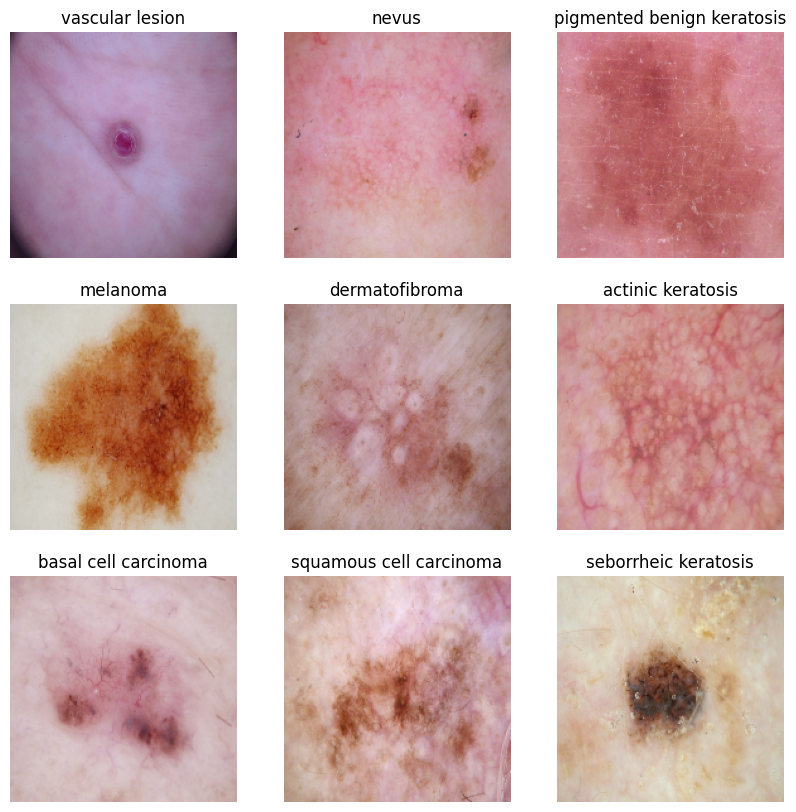

In [31]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
seen = []
img_cnt = 0
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(10):
  for i in range(batch_size):
    if class_names[labels[i]] not in seen:
      print(img_cnt, class_names[labels[i]])

      ax = plt.subplot(3, 3, img_cnt + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

      seen.append(class_names[labels[i]])
      img_cnt += 1

    if len(seen) == 9:
      break

# Plotting the images
# plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [32]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [33]:
tf. __version__

'2.12.0'

In [34]:
### Your code goes here
num_classes = len(class_names)

model = Sequential([
                    # layers.experimental.prerprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

                    layers.Conv2D(16, 3, padding="same", activation="relu"),
                    layers.MaxPooling2D(),

                    layers.Conv2D(32, 3, padding="same", activation="relu"),
                    layers.MaxPooling2D(),

                    layers.Conv2D(64, 3, padding="same", activation="relu"),
                    layers.MaxPooling2D(),

                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(num_classes)

])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [35]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [37]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 263s 1s/step - loss: 2.0190 - accuracy: 0.2383 - val_loss: 1.8872 - val_accuracy: 0.2595
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.6710 - accuracy: 0.4129 - val_loss: 1.4682 - val_accuracy: 0.4922
Epoch 3/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4235 - accuracy: 0.5011 - val_loss: 1.6263 - val_accuracy: 0.4541
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 1.3451 - accuracy: 0.5296 - val_loss: 1.3692 - val_accuracy: 0.5593
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2647 - accuracy: 0.5474 - val_loss: 1.5042 - val_accuracy: 0.4855
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2363 - accuracy: 0.5547 - val_loss: 1.3477 - val_accuracy: 0.5570
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 1.1742 - accuracy: 0.5792 - val_loss: 1.3646 - val_accuracy: 0.5459
Epoch 8/20
56

In [39]:
model.save("/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Model_1")

### Visualizing training results

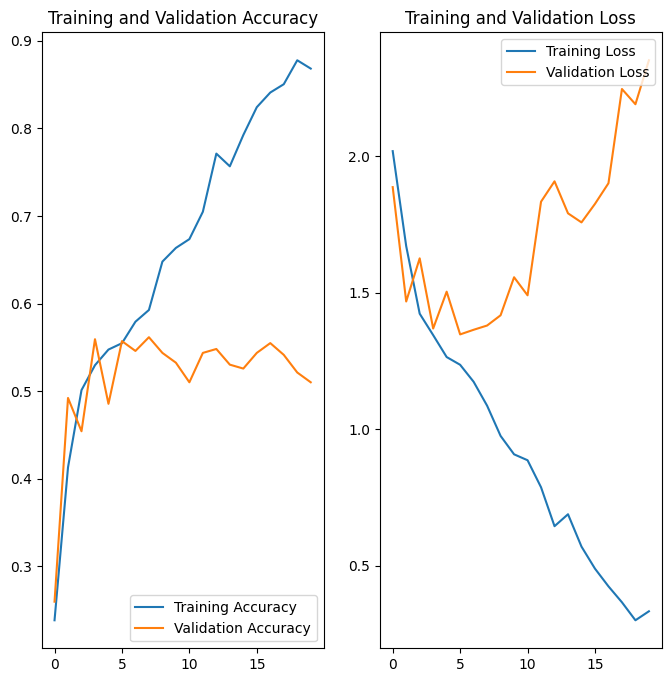

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Write your findings here

Findings:
1. In the first graph, The Training and Validation Accuracy increases till the 0.55 , however, the validation Accuracy is plateaued while the Training Accuracy boosted , This is an Indication of Overfit Model

2. In the second Graph, we see similar trend with decrease of Training and Validation Loss. While the training loss decrease gradually, there is increase in Validation loss which explains overfit of model and also imbalnce of data set classes.

In [41]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augmentation = keras.Sequential(
    [
     layers.RandomFlip("horizontal",
                       input_shape=(img_height, img_width, 3)),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.1),
    ]
)

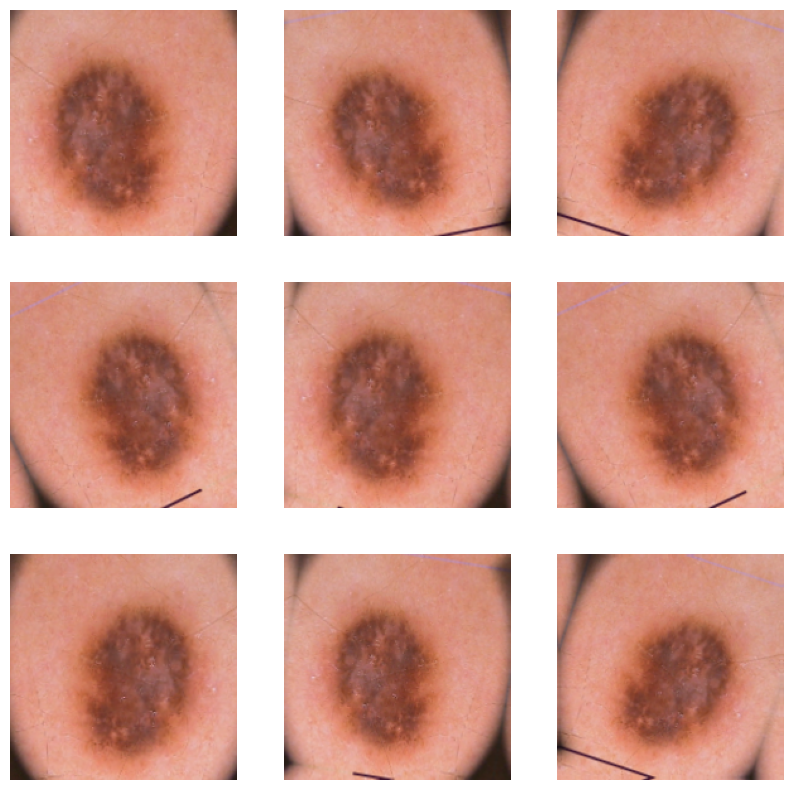

In [42]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [43]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
num_classes = 9
model = Sequential([
                    data_augmentation,
                    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

                    layers.Conv2D(64, 3, padding="same", activation="relu"),
                    layers.MaxPooling2D(),

                    layers.Conv2D(128, 3, padding="same", activation="relu"),
                    layers.MaxPooling2D(),

                    layers.Conv2D(128, 3, padding="same", activation="relu"),
                    layers.MaxPooling2D(),

                    layers.Conv2D(64, 3, padding="same", activation="relu"),
                    layers.MaxPooling2D(),

                    layers.Dropout(0.35),

                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(num_classes)

])

### Compiling the model

In [44]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [45]:
## Your code goes here, note: train your model for 20 epochs

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
56/56 [==============================] - 11s 119ms/step - loss: 2.0723 - accuracy: 0.1886 - val_loss: 2.0441 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 6s 107ms/step - loss: 1.9950 - accuracy: 0.2360 - val_loss: 1.8933 - val_accuracy: 0.2998
Epoch 3/20
56/56 [==============================] - 6s 107ms/step - loss: 1.8453 - accuracy: 0.2963 - val_loss: 1.8268 - val_accuracy: 0.2998
Epoch 4/20
56/56 [==============================] - 6s 105ms/step - loss: 1.7328 - accuracy: 0.3616 - val_loss: 1.6361 - val_accuracy: 0.4407
Epoch 5/20
56/56 [==============================] - 6s 102ms/step - loss: 1.6661 - accuracy: 0.4012 - val_loss: 1.5572 - val_accuracy: 0.4340
Epoch 6/20
56/56 [==============================] - 6s 104ms/step - loss: 1.6144 - accuracy: 0.4297 - val_loss: 1.5646 - val_accuracy: 0.4474
Epoch 7/20
56/56 [==============================] - 6s 102ms/step - loss: 1.5580 - accuracy: 0.4470 - val_loss: 1.5278 - val_accuracy: 0.4787
Epoch

In [46]:
model.save("/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/model_2")

### Visualizing the results

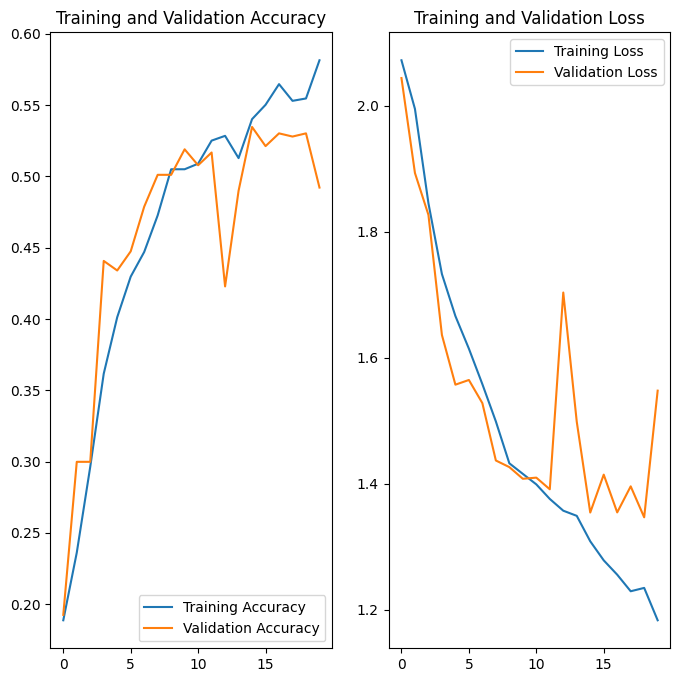

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Yes, There is improvment in the model. The overall train and Validation Accuracy are moving together, and the same goes for the loss as well. However, There is still some room for improvement of model since the overall validation accuracy is just over 0.55

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

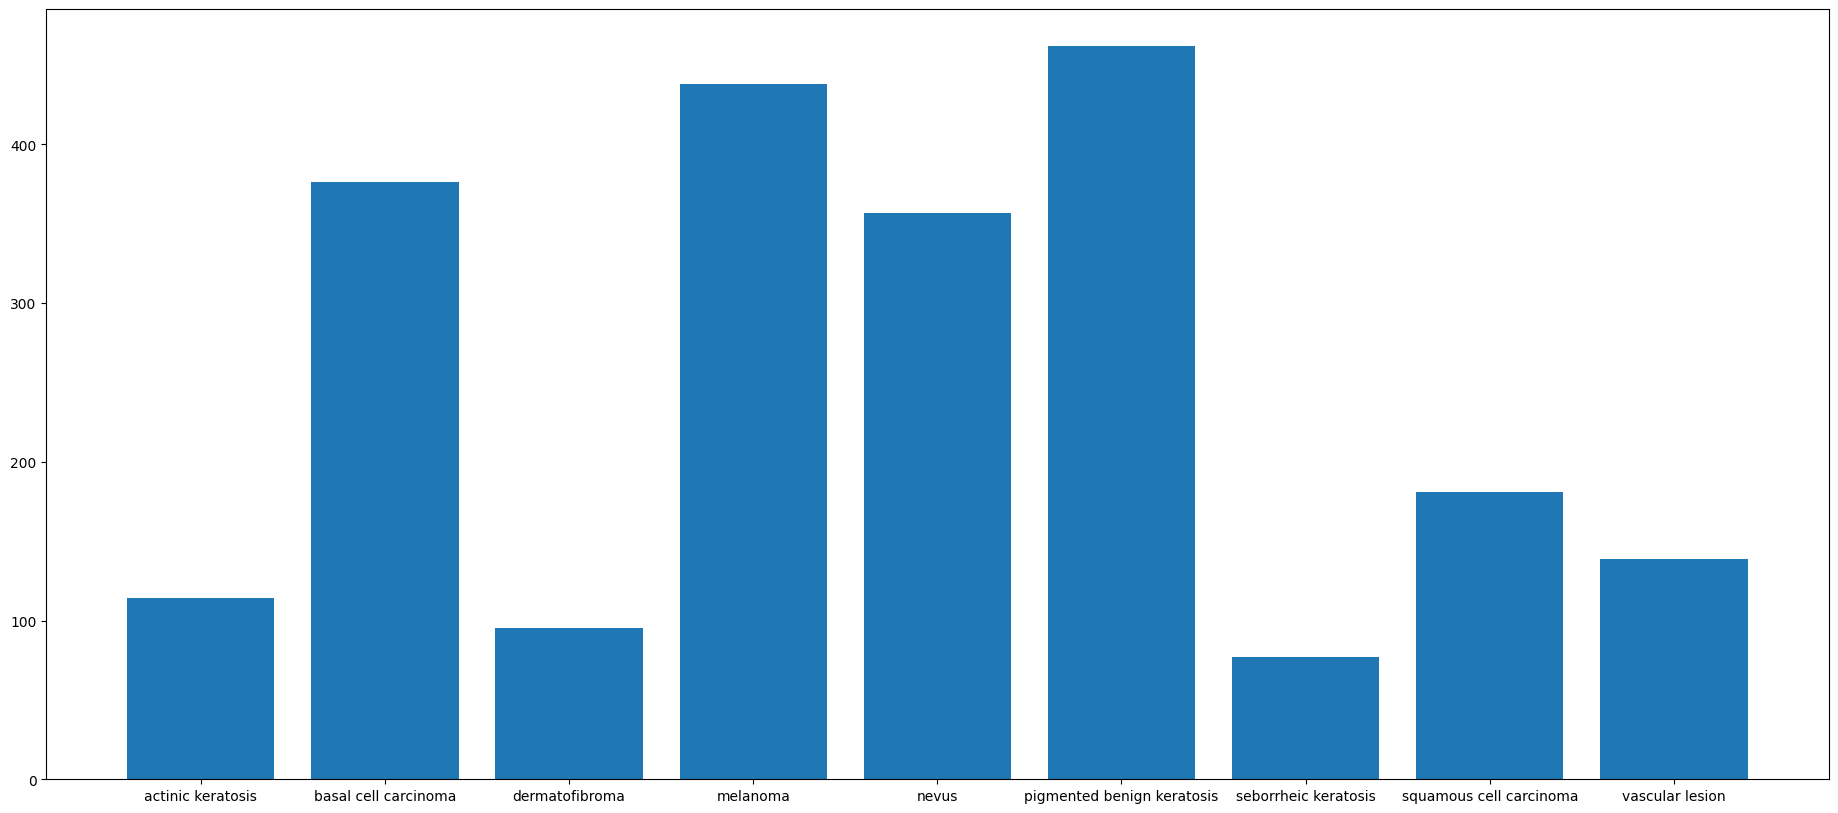

In [48]:
## Your code goes here.

path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])


count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(23,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
*Ans*: **seborrheic keratosis has least number of samples**
#### - Which classes dominate the data in terms proportionate number of samples?
*Ans*: **pigmented benign keratosis, Melanoma, basal cell carcinoma and nevus  have proprtionate number of classes.**


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [49]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [51]:
path_to_training_dataset="/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F61DD5EB7C0>:  58%|█████▊    | 291/500 [00:13<00:09, 21.04 Samples/s]


KeyboardInterrupt: ignored

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [54]:
data_dir_train.glob

<bound method Path.glob of PosixPath('/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')>

In [55]:
from glob import glob
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4802
4802


### Lets see the distribution of augmented data after adding new images to the original training data.

In [56]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011040.jpg_ead08fc5-8e67-4442-8781-87d05a29945e.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011139.jpg_678165a7-f46d-49b3-a0d1-20452142b8e4.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011052.jpg_4f517a89-f018-42b2-a6a6-a3d6dc817de4.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011128.jpg_50923422-1491-459d-b2b5-b55735693434.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Col

In [57]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [58]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [59]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-59-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [60]:
new_df.head()

,Path,Label
0,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
1,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
2,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
3,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
4,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis


In [61]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
actinic keratosis             916
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [62]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [63]:
data_dir_train='/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7041 files belonging to 9 classes.
Using 5633 files for training.


#### **Todo:** Create a validation dataset

In [64]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7041 files belonging to 9 classes.
Using 1408 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [65]:
## your code goes here
num_classes = 9
model = Sequential([
                    data_augmentation,
                    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

                    layers.Conv2D(64, 3, padding="same", activation="relu"),
                    layers.MaxPooling2D(),

                    layers.Conv2D(128, 3, padding="same", activation="relu"),
                    layers.MaxPooling2D(),

                    layers.Conv2D(128, 3, padding="same", activation="relu"),
                    layers.MaxPooling2D(),

                    layers.Conv2D(64, 3, padding="same", activation="relu"),
                    layers.MaxPooling2D(),

                    layers.Normalization(axis=None),

                    layers.Dropout(0.35),

                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(num_classes)

])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [66]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [67]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
177/177 [==============================] - 48s 247ms/step - loss: 2.0342 - accuracy: 0.1987 - val_loss: 2.4947 - val_accuracy: 0.2209
Epoch 2/30
177/177 [==============================] - 44s 240ms/step - loss: 1.7561 - accuracy: 0.3174 - val_loss: 1.6446 - val_accuracy: 0.4134
Epoch 3/30
177/177 [==============================] - 44s 238ms/step - loss: 1.5572 - accuracy: 0.4065 - val_loss: 1.5191 - val_accuracy: 0.4368
Epoch 4/30
177/177 [==============================] - 47s 254ms/step - loss: 1.4569 - accuracy: 0.4481 - val_loss: 1.3390 - val_accuracy: 0.4815
Epoch 5/30
177/177 [==============================] - 46s 249ms/step - loss: 1.3802 - accuracy: 0.4768 - val_loss: 1.3875 - val_accuracy: 0.4822
Epoch 6/30
177/177 [==============================] - 43s 239ms/step - loss: 1.3126 - accuracy: 0.4957 - val_loss: 1.2829 - val_accuracy: 0.4986
Epoch 7/30
177/177 [==============================] - 43s 237ms/step - loss: 1.2593 - accuracy: 0.5230 - val_loss: 1.1749 - val_ac

In [68]:
model.save("/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/model_3")

#### **Todo:**  Visualize the model results

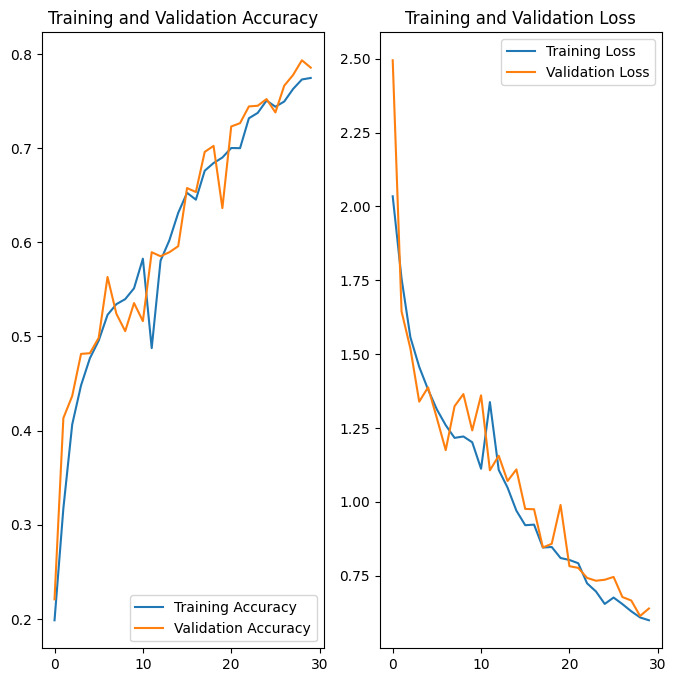

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

#### Ans:
*   Yes, we got rid of Underfitting by increasing number of epoch and Agumeting
*   Images in Train Data set, we got rid of overfitting by adding dropout layer, Normalization and making model more complex by adding more neurons


